# 5 Modeling

## Table of Contents:

* [5.1 Introduction](#5.1_Introduction)
* [5.2 Import Packages](#5.2_Import_Packages)
* [5.3 Load the Data](#5.3_Load_the_Data)
* [5.4 Random Forest Classifier](#5.4_Random_Forest_Classifier)
* [5.5 ](#5.5_)
* [5.6 ](#5.6_)
* [5.7 ](#5.7_)
* [5.8 Summary and Next Steps](#5.8_Summary_and_Next_Steps)

Objectives:


* Apply two to three different modeling methods to  dataset and evaluated the performance using the appropriate metrics for their modeling methods.
* Identify which model as the best model.
 * Fit your models with a training dataset 
   * hyperaparameter testing with cross validation
 * Review model outcomes — Iterate over additional models as needed
   * accuracy, recall, precision, and F1.
 * Identify the final model that you think is the best model for this project
   * considerations include computational complexity, scalability, and maintenance costs




Some preliminary ideas:
* RF classifier
* XG Boost
* FB Prophet (do I need to redo my train/test split since I'm forecasting?)

## 5.1 Introduction<a id='5.1_Introduction'></a>

## 5.2 Import Packages<a id='5.2_Import_Packages'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
import time
import random

%matplotlib inline
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss

## 5.3 Load the Data<a id='5.3_Load_the_Data'></a>

In [2]:
# change directories to where the processed data is located.

path = 'D:\Documents\Springboard\Capstone 2 - heavy drinking project\data'
os.chdir(path)
os.getcwd()

'D:\\Documents\\Springboard\\Capstone 2 - heavy drinking project\\data'

In [3]:
#Note, the index column gets loaded as its own column, 'Unnamed: 0'
#We should remove it as to not have it included with our features.

X_train = pd.read_csv('X_train.csv').drop(columns=['Unnamed: 0'])
X_test = pd.read_csv('X_test.csv').drop(columns=['Unnamed: 0'])
y_train = pd.read_csv('y_train.csv')
y_test =pd.read_csv('y_test.csv')

X_train_tma = pd.read_csv('X_train_tma.csv').drop(columns=['Unnamed: 0'])
X_test_tma = pd.read_csv('X_test_tma.csv').drop(columns=['Unnamed: 0'])
y_train_tma =pd.read_csv('y_train_tma.csv')
y_test_tma = pd.read_csv('y_test_tma.csv')

In [4]:
#scale the raw/interpolated data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
#scale the triangular-moving-average smoothed data
scaler_t = StandardScaler()
scaler_t.fit(X_train_tma)
X_train_scaled_tma = scaler_t.transform(X_train_tma)
X_test_scaled_tma = scaler_t.transform(X_test_tma)

In [6]:
#convert y_train and y_test from continuous variable to binary class. Do the same for _tma.
#here we define 1 as legally drunk and 0 as legally sober.

y_train.order_3[y_train.order_3 >= 0.08] = 1
y_train.order_3[y_train.order_3 < 0.08] = 0
y_train = y_train.order_3.astype('int32').to_numpy()

y_test.order_3[y_test.order_3 >= 0.08] = 1
y_test.order_3[y_test.order_3 < 0.08] = 0
y_test = y_test.order_3.astype('int32').to_numpy()


y_train_tma.tma[y_train_tma.tma >= 0.08] = 1
y_train_tma.tma[y_train_tma.tma < 0.08] = 0
y_train_tma = y_train_tma.tma.astype('int32').to_numpy()

y_test_tma.tma[y_test_tma.tma >= 0.08] = 1
y_test_tma.tma[y_test_tma.tma < 0.08] = 0
y_test_tma = y_test_tma.tma.astype('int32').to_numpy()

<ipython-input-6-2d567ae4f393>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train.order_3[y_train.order_3 >= 0.08] = 1
<ipython-input-6-2d567ae4f393>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train.order_3[y_train.order_3 < 0.08] = 0
<ipython-input-6-2d567ae4f393>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test.order_3[y_test.order_3 >= 0.08] = 1
<ipython-input-6-2d567ae4f393>:9: SettingWithCopyWarning: 
A value 

From here below we don't look at TMA, we only look at raw/interpolate data

In [7]:
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.753
Random Forest: f1-score=0.748


In [8]:
cnf_matrix = confusion_matrix(y_test, y_pred)

In [9]:
cnf_matrix

array([[ 802,  493],
       [ 182, 1256]], dtype=int64)

In [10]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

In [11]:
precision

array([0.52616173, 0.71812464, 1.        ])

In [12]:
recall

array([1.        , 0.87343533, 0.        ])

In [13]:
thresholds

array([0, 1])

Average precision-recall score: 0.69


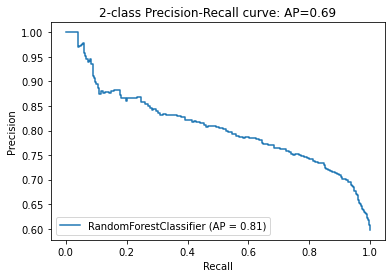

In [14]:
average_precision = average_precision_score(y_test, y_pred)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

disp = plot_precision_recall_curve(clf, X_test_scaled, y_test)
_=disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

30


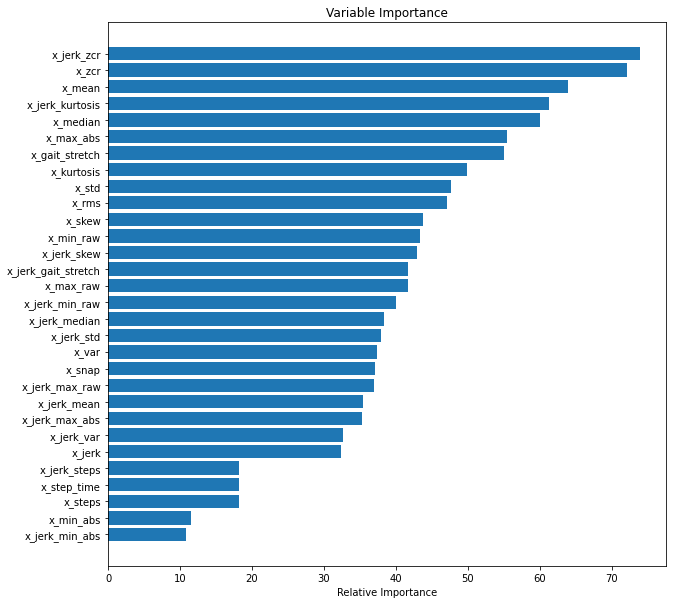

In [15]:
#Feature Importance:

feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

What about for TMA

In [16]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled_tma, y_train_tma)
y_pred = model_res.predict(X_test_scaled_tma)
y_pred_prob = model_res.predict_proba(X_test_scaled_tma)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test_tma, y_pred)

f1 = f1_score(y_test_tma, y_pred, average='weighted')
cm = confusion_matrix(y_test_tma, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.793
Random Forest: f1-score=0.791


In [17]:
cnf_matrix = confusion_matrix(y_test_tma, y_pred)
cnf_matrix

array([[ 968,  449],
       [ 139, 1290]], dtype=int64)

Average precision-recall score: 0.72


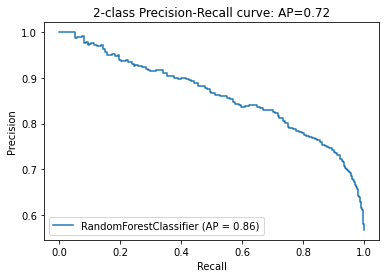

In [18]:
average_precision = average_precision_score(y_test_tma, y_pred)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

disp = plot_precision_recall_curve(clf, X_test_scaled_tma, y_test_tma)
_=disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

30


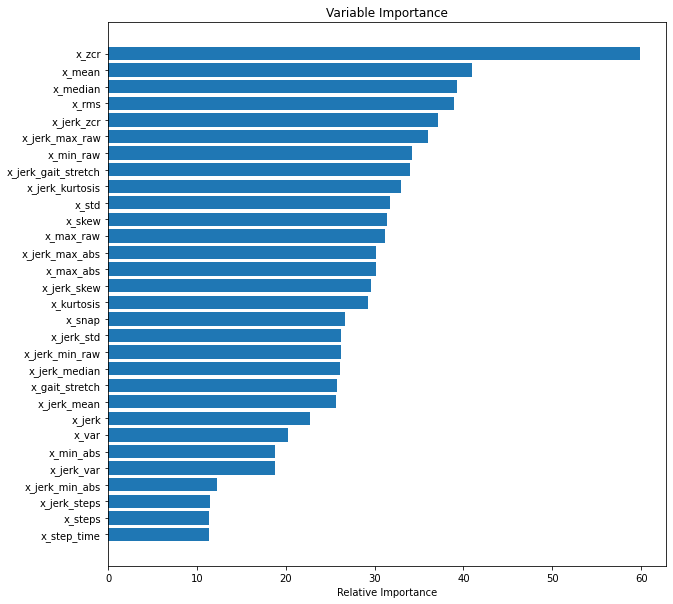

In [19]:
#Feature Importance:

feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train_tma.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()